In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tifffile
from skimage import exposure
from sklearn import decomposition

In [4]:
def colour_correction(image):
    color_corrected_image = np.zeros((2048,2048,3))
    
    #splitting image into RGB channels
    red_channel = image[:,:,0].flatten().astype(np.float64)
    green_channel = image[:,:,1].flatten().astype(np.float64)
    blue_channel = image[:,:,2].flatten().astype(np.float64)
    
    #taking inverse of the first coeffcient matrix for colour correction
    coefficient_matrix1  = np.array([[0.811, 0.176, 0.021], [0.259,0.621, 0.132], [0.151, 0.204, 0.657]])
    inverse_matrix = np.linalg.inv(coefficient_matrix1)
    
    #RGB Matrix of size 4194304x3
    rgb_matrix = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    
    #Taking transpose so the RGB Matrix is now 3x4194304
    unit = np.array([[1,0,0],[0,1,0],[0,0,1]])
    rgb_matrix = np.matmul(rgb_matrix, unit).T
    
    #The new RGB channels after colour correction 
    new_rgb_matrix = inverse_matrix@rgb_matrix
    new_rgb_matrix = np.matmul(unit,new_rgb_matrix).T
    
    #reshaping to get the colour corrected image
    color_corrected_image[:,:,0] = np.reshape(new_rgb_matrix[:,0],(2048,2048))
    color_corrected_image[:,:,1] = np.reshape(new_rgb_matrix[:,1],(2048,2048))
    color_corrected_image[:,:,2] = np.reshape(new_rgb_matrix[:,2],(2048,2048))
    return color_corrected_image

In [5]:
def hsi_transform(image):
    
    red_channel = image[:,:,0].flatten().astype(np.float64)
    green_channel = image[:,:,1].flatten().astype(np.float64)
    blue_channel = image[:,:,2].flatten().astype(np.float64)
    
    #stacking rgb channels to make a 4194304x3 matrix
    rgb_matrix = np.stack((red_channel, green_channel, blue_channel), axis=-1).astype(np.float64)
    
    #second coefficient matrix for transform to HSI color space
    coefficient_matrix_2 = [[1/3,1/3,1/3],[1/np.sqrt(6),1/np.sqrt(6),-2/np.sqrt(6)],[1/np.sqrt(2),-1/np.sqrt(2),0]]
    unit = np.array([[1,0,0],[0,1,0],[0,0,1]])
    
    #taking transpose of rgb matrix
    rgb_matrix = np.matmul(rgb_matrix, unit).T
    
    #matmul to HSI
    hsi_matrix = coefficient_matrix_2@rgb_matrix
    
    #pulling out intensity channel
    intensity = hsi_matrix[0]
    v1 = hsi_matrix[1]
    v2 = hsi_matrix[2]
    
    #reshape intensity channel for intensity image
    intensity_image = np.reshape(np.asarray(intensity),image[:,:,0].shape)
    return intensity_image,hsi_matrix

In [7]:
def clahe(image):
    
    #clipping the negative values
    image = image.clip(0,1023)
    image = image.astype(np.uint16)
    
    #applying clahe on the intensity channel taking clip limit = 0.01 and grid size as 32x32
    enhanced_image = exposure.equalize_adapthist(image, clip_limit = 0.01, kernel_size = (32,32))
    
    #normalizing intensity values between 0 and 255
    enhanced_image_normalized = cv2.normalize(enhanced_image,np.zeros((2048,2048)),0,255, cv2.NORM_MINMAX)
    return enhanced_image_normalized

In [9]:
def pca(image):
    red_channel = image[:,:,0].flatten().astype(np.float64)
    green_channel = image[:,:,1].flatten().astype(np.float64)
    blue_channel = image[:,:,2].flatten().astype(np.float64)
    
    #stacking rgb channels to make a 4194304x3 matrix(matrix with 3 features)
    rgb_matrix = np.stack((red_channel, green_channel, blue_channel), axis=-1).astype(np.float64)
    
    #no of principal components
    p_components = 3
    pca = decomposition.PCA(n_components = p_components)
    
    #PC are the principal components
    PC = pca.fit_transform(rgb_matrix)
    
    #reshaping components to get PC images
    PC_image = np.zeros((2048,2048,3))
    PC_image[:,:,0] = np.reshape(PC[:,0],image[:,:,0].shape)
    PC_image[:,:,1] = np.reshape(PC[:,1],image[:,:,0].shape)
    PC_image[:,:,2] = np.reshape(PC[:,2],image[:,:,0].shape)
    
    #normalizing the values between o and 255
    PC_image_norm = np.zeros((2048,2048,3))
    PC_image_norm[:,:,0] = cv2.normalize(PC_image[:,:,0],np.zeros((2048,2048)),0,255, cv2.NORM_MINMAX)
    PC_image_norm[:,:,1] = cv2.normalize(PC_image[:,:,1],np.zeros((2048,2048)),0,255, cv2.NORM_MINMAX)
    PC_image_norm[:,:,2] = cv2.normalize(PC_image[:,:,2],np.zeros((2048,2048)),0,255, cv2.NORM_MINMAX)
    
    #return first principal component
    return PC_image_norm[:,:,0]

In [11]:
def histogram_match(source, reference):
    
    #source is clahe enhanced intensity channel
    #reference is PCA first component
    matched_image = np.zeros_like(source,dtype=np.float64)
    source = source.astype(np.uint16)
    reference = reference.astype(np.uint16)
    source_array = np.array(source.flatten())
    reference_array = np.array(reference.flatten())
    def match_cumulative_cdf(source,reference):
        src_lookup = source.reshape(-1)
        
        #source and reference bincount
        src_counts = np.bincount(src_lookup)
        ref_counts = np.bincount(reference.reshape(-1))
        ref_values = np.nonzero(ref_counts)[0]
        
        #ref histogram
        ref_counts = ref_counts[ref_values]
        
        #cdf source
        src_quantiles = np.cumsum(src_counts)
        
        #cdf reference
        ref_quantiles = np.cumsum(ref_counts)
        
        #interpolate soucre and reference cdf
        interp_values = np.interp(src_quantiles,ref_quantiles, ref_values)
        return interp_values[src_lookup].reshape(source.shape)
    matched_image = match_cumulative_cdf(source, reference)
    return matched_image

In [41]:
def rgb_transform(Enhanced_Intensity_Channel, hsi_matrix):
    
    #Replacing the intensity component in the HSI Matrix
    Enhanced_Intensity = np.array(Enhanced_Intensity_Channel.flatten())
    hsi_matrix[0] = Enhanced_Intensity
    
    #Third coefficient matrix for transform to RGB
    coefficient_matrix_3 = [[1,1/np.sqrt(6),1/np.sqrt(2)],[1,1/np.sqrt(6),-1/2],[1,-2/np.sqrt(6),0]]
    
    #Transform back to RGB
    new_rgb_matrix = coefficient_matrix_3@hsi_matrix
    
    #new_rgb_image
    new_rgb_img = np.zeros((2048,2048,3))
    new_rgb_img[:,:,0] = np.reshape(np.asarray(new_rgb_matrix[0]),new_rgb_img[:,:,1].shape)
    new_rgb_img[:,:,1] = np.reshape(np.asarray(new_rgb_matrix[1]),new_rgb_img[:,:,1].shape)
    new_rgb_img[:,:,2] = np.reshape(np.asarray(new_rgb_matrix[2]),new_rgb_img[:,:,1].shape)
    return new_rgb_img

In [14]:
def adaptive_gamma_correction(image):
    def image_agcwd(image, a=0.5):
        
        #taking the shape of the image h = 2048, w = 2048
        h,w = image.shape[:2]
        
        #calculating histogram and bins
        hist, bins = np.histogram(image.flatten(), 256, [0,256])
        cdf = hist.cumsum()
        cdf_normalized = cdf/cdf.max()
        prob_normalized = hist/hist.sum()

        unique_intensity = np.unique(image)
        #max and min intensity values
        intensity_max = unique_intensity.max()
        intensity_min = unique_intensity.min()
        
        #max and min probability values 
        prob_min = prob_normalized.min()
        prob_max = prob_normalized.max()
        
        #weighed probability function for calculated P(weighed) = ((P - Pmax)/(Pmax - Pmin))**a
        #a value has been experimentally set to 0.5
        pn_temp = (prob_normalized - prob_min)/(prob_max - prob_min)
        pn_temp[pn_temp>0] = prob_max*(pn_temp[pn_temp>0]**a)
        pn_temp[pn_temp<0] = prob_max*(-((-pn_temp[pn_temp<0])**a))
        
        #normalized weighed probability
        prob_normalized_wd = pn_temp/ pn_temp.sum()
        #cdf
        cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
        
        #adaptive gamma correction is given by image**(1-cdf)
        #truncating cdf value to prevent overenhancing in the brighter regions
        inverse_cdf = np.maximum(0.75,1-cdf_prob_normalized_wd)
        
        #normalizing luminiscence values
        img_new = image.copy()
        for i in unique_intensity:
            img_new[image==i] = np.round(255*(i/255)** inverse_cdf[i])
        return img_new
    
    #Transforming to YCrCb for adaptive gamma correction 
    YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    #pulling out the luminiscence component
    Y = YCrCb[:,:,0]
    
    #calculating adaptive gamma correction for luminiscence
    result= image_agcwd(Y, a=0.5)
    YCrCb[:,:,0] =  result
    
    #convert back to RGB Color-Space
    img_output = cv2.cvtColor(YCrCb, cv2.COLOR_YCrCb2BGR)
    img_output_new = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
    return img_output_new

In [ ]:
#read input Planetary Multi-Spectral Image (8-Bit)
Input_PMS_Image = tifffile.imread("/home/training/Harmionee/MCC_Images/MCC_MRC_20150423T072306117_D_D32.IMG (RGB).tif")

In [42]:
#PLEASANT Workflow
#1. Color Correction
Image_CCI = colour_correction(Input_PMS_Image)

#2. Transform to HSI Space
Intensity_Image, hsi_matrix = hsi_transform(Image_CCI)

#3.Enhance Intensity_Image/ Intensity_Channel with CLAHE
CLAHE_Enhanced_Intensity = clahe(Intensity_Image)

#4. Calculate First Principal Component of the CCI (Color-Corrected Image)
PCA_1 = pca(Image_CCI)

#5. Histogram Matching of the CLAHE enhanced Intensity Channel by taking PCA1 as the reference
Image_HM = histogram_match(CLAHE_Enhanced_Intensity, PCA_1)

#6. Transform the new hsi matrix with the histogram matched intensity channel back to RGB color Space
New_RGB_Image = rgb_transform(CLAHE_Enhanced_Intensity, hsi_matrix)

#save the image and convert to png to map all the values between 0,255
tifffile.imsave('/home/training/Harmionee/MCC_Images/sample.tif',New_RGB_Image)

#Re-read the image using cv2 so that it is read in BGR
RGB_image = cv2.imread('/home/training/Harmionee/MCC_Images_8Bit_Im3/Pital_Crater_Composite.png')

#7.Perform Adaptive Gamma Correction on the image
Image_GC = adaptive_gamma_correction(RGB_image)

Text(0.5,1,'Input Planetary Image')

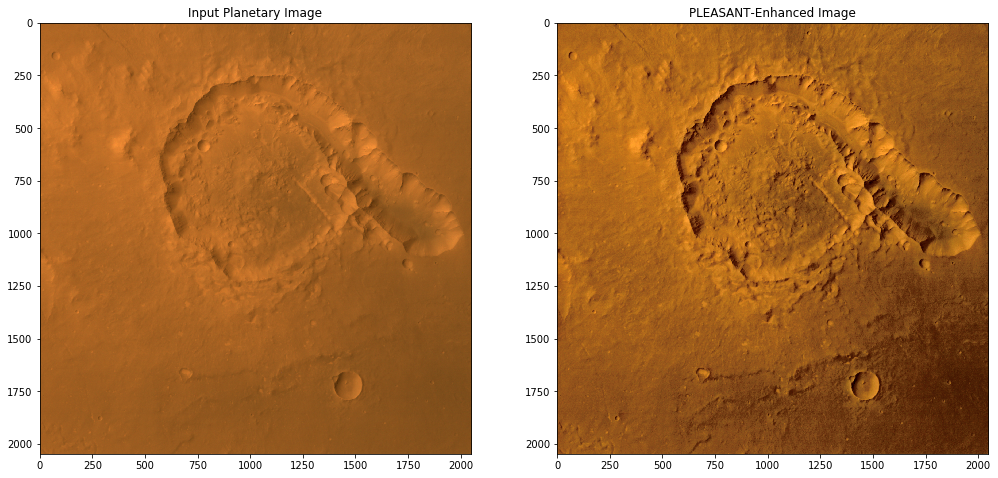

In [37]:
#PLEASANT Enhanced image
figs, axs = plt.subplots(1,2,figsize=(17,17))
axs[1].imshow(Image_GC)
axs[1].set_title('PLEASANT-Enhanced Image')
axs[0].imshow(Input_PMS_Image)
axs[0].set_title('Input Planetary Image')